# Machine Learning for Post-Processing NWM Data 
**Authors: Savalan Naser Neisary (PhD Student, CIROH & The University of Alabama)**




### 1. Introduction 
#### 1.1. Overview of the Workshop’s Goals and Structure.

This is going to be 90 minutes workshop in which we will:
- An overview of ML model development in SageMaker.
- Learn how to develop a simple Long-Short-Term Memory (LSTM) on SageMaker to post-process NWM data. 
- Learn how to use different CPUs and GPUs. 
- Learn how to use Git, Conda, and Amazon S3 buckets in our model development process.


We will first review the theoretical background behind the LSTM and the pros and cons of the most powerful LSMT algorithm. Then, we will start the hands-on part of the workshop. Next, we plan to preprocess the data and start model development using the Pytorch library. After that, we will discuss hyperparameter tuning. Finally, we will evaluate and compare the model with NWM results. 
#### 1.2. Post-processing Hydrological Predictions

Effective and sustainable management of water resources is crucial to provide adequate water supply for human societies, regardless of their geographical location. Having an accurate and precise prediction of future hydrological variables, including streamflow, is a critical component for effective water systems management, and various studies presented different methods, such as post-processing, to increase the accuracy of the hydrological predictions. Post-processing methods seek to quantify the uncertainties of hydrological model outcomes and correct their biases using a statistical model to transform model outputs based on the relationship(s) between observations and model. According to the literature, Machine Learning (ML) models have proved useful in post-processing the results of other ML or physical-based hydrological models. Therefore, in this workshop, we will use LSTM to post-process streamflow outputs of a physical-baed model. 
#### 1.3. Post-processing Retrospective National Water Model (NWM) Streamflow Data

NOAA introduced the NWM to address the need for an operational large-scale hydrological forecasting model to provide streamflow predictions in CONUS. While it can predict streamflow in 2.7 billion water reaches, according to the literature, NWM has low accuracy in regions west of the 95th meridian with drought and low-flow problems and in controlled basins with extensive water infrastructure. This low performance in western US watersheds is due to the lack of water operation consideration and a comprehensive groundwater and snow model besides calibrating NWM, mostly with watersheds in the eastern US. To compensate for NWM shortcomings in this workshop, we will demonstrate how to use LSTM to increase accuracy by post-processing the NWM outputs and adding the human activity impact.   

###### Recommended Resources:
- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow.
- C4.5: Programs for Machine Learning.
- A Holistic Comparative Application of Artificial Intelligence Methods in Reservoir Inflow Forecast. 






### 2. Theoretical Background 

#### 2.1. Long Short Term Memory (LSTM)
Long Short-Term Memory networks, commonly known as LSTMs, are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber in 1997 and have since been a fundamental component in the progression of deep learning, particularly in sequences and time series data. LSTMs are designed to avoid the long-term dependency problem, allowing them to remember information for extended periods. This is crucial in tasks such as language translation, speech recognition, and time series forecasting where the context and past information significantly influence the current output.

LSTMs achieve this capability through a complex architecture that includes several gates: the input gate, the forget gate, and the output gate. Each gate in an LSTM cell regulates the flow of information, deciding what to retain and what to discard, thus effectively maintaining the cell state across time steps. The gates are composed of sigmoid neural net layers that output numbers between zero and one, describing how much of each component should be let through. This gating mechanism differentiates LSTMs from other neural networks by giving them finer control over the gradient flow and state updates, which helps in maintaining stable gradients over time, thereby making them highly effective for tasks involving sequential data.

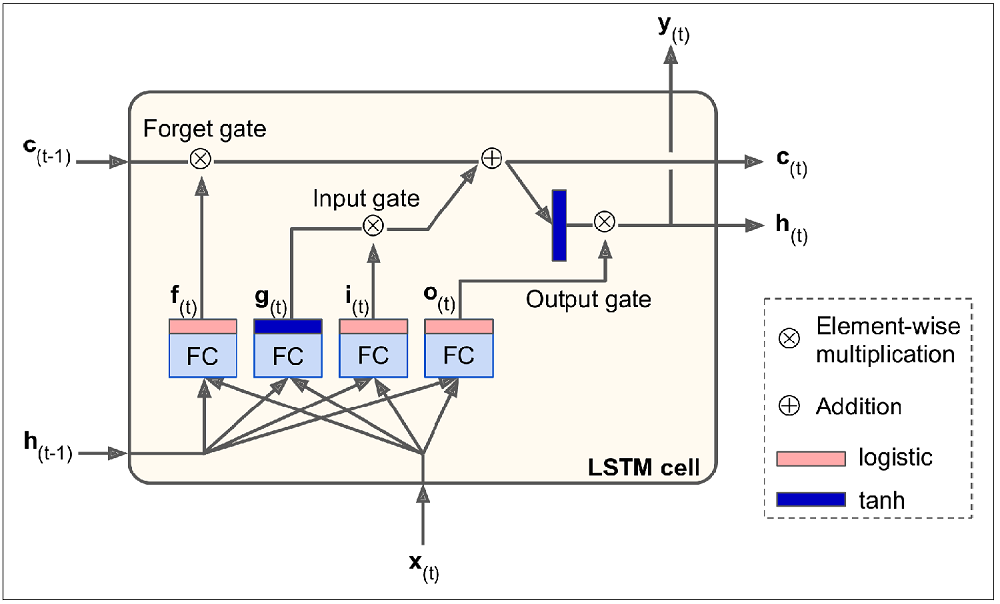


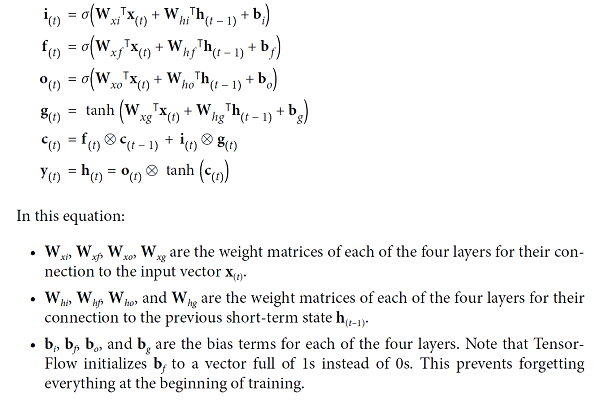


#### 3.3. Import the Python Libraries
Next we will import the libraries that we need. 

In [1]:
# my packages
from evaluation_table import EvalTable
from figure_generator import EvalPlot
from model import CustomBiLSTM
from tuning_tools import tuning_game, tune_model 
from data_preprocess import data_prepare, data_split
from final_eval import general_viz, regime_eval, signature_eval, eval_drought

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import joblib

# system packages
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os

# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this

# data analysis packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

/home/jovyan/envs/devcon_2025/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## 4. Data Preprocessing
#### 4.1. Overview of the USGS Stream Station
- The dataset we will use provides the data for several stations in the Great Salt Lake (GSL) watershed. 
- The dataset contains climate variables, such as precipitation and temperature, water infrastructure, storage percentage, and watershed characteristics, such as average area and elevation. 
You can see the location of the station and its watershed in the Figure below. 

#### 4.2. Load Dataset

In [2]:
# List of station IDs that are of interest.
# stations = ['10154200', '10155000', '10156000']
stations = ['10011500', '10068500', '10126000']
# Read a CSV file into a DataFrame and set the first column as the index.
df = pd.read_parquet(f'{input_path}data_model_input.parquet')

# Convert the station_id column to string data type.
df.station_id = df.station_id.astype(str)

# Convert the 'datetime' column to datetime objects.
df.datetime = pd.to_datetime(df.datetime)
# df = df[df['swe'] != 0]
# Filter the DataFrame to include only the rows where 'station_id' is in the 'stations' list.
dataset = df[df['station_id'].isin(stations)]

# Extract a list of unique station IDs from the modified dataset.
station_list = dataset.station_id.unique()


In [3]:
dataset.columns

Index(['station_id', 'NHDPlusid', 'datetime', 'state', 'dec_lat_va',
       'dec_long_va', 'total_area', 'basin_mean_elevation', 'basin_mean_slope',
       'imperv_perc', 'agri_perc', 'forest_perc', 'day_of_year', 'min', 'max',
       'mean', 'median', 's1', 's2', 'precipitation', 'temperature', 'storage',
       'swe', 'NWM_flow', 'flow_cms'],
      dtype='object')

In [4]:
aa = dataset[['station_id', 'NHDPlusid', 'state', 'dec_lat_va',
       'dec_long_va', 'total_area']]

aa_unique = aa.drop_duplicates().reset_index(drop=True)

aa_unique

,station_id,NHDPlusid,state,dec_lat_va,dec_long_va,total_area
0,10011500,7887898,ut,40.965225,-110.853508,456.302250
1,10126000,4605050,ut,41.576321,-112.100782,17854.969503
2,10068500,4472049,id,42.401593,-111.356875,9368.257952


In [16]:
df_loaded = pd.read_parquet(f'{input_path}/nwm_swe.parquet', engine='pyarrow')
df_loaded.rename(columns={'ids': 'station_id', 'time': 'datetime', 'swe': 'swe_nwm'}, inplace=True)
df_loaded

,station_id,datetime,swe_nwm
0,10011500,1979-02-01,8.133719
1,10011500,1979-02-02,8.987514
2,10011500,1979-02-03,9.603156
3,10011500,1979-02-04,9.547283
4,10011500,1979-02-05,9.437338
...,...,...,...
450011,10171000,2023-01-28,51.228554
450012,10171000,2023-01-29,50.928432
450013,10171000,2023-01-30,50.812447
450014,10171000,2023-01-31,51.314522


In [30]:
merged_df = pd.merge(dataset, df_loaded, on=['station_id', 'datetime'], how='inner')
merged_df.columns

Index(['station_id', 'NHDPlusid', 'datetime', 'state', 'dec_lat_va',
       'dec_long_va', 'total_area', 'basin_mean_elevation', 'basin_mean_slope',
       'imperv_perc', 'agri_perc', 'forest_perc', 'day_of_year', 'min', 'max',
       'mean', 'median', 's1', 's2', 'precipitation', 'temperature', 'storage',
       'swe', 'NWM_flow', 'flow_cms', 'swe_nwm'],
      dtype='object')

In [32]:
merged_df = merged_df[['station_id', 'NHDPlusid', 'datetime', 'state', 'dec_lat_va',
       'dec_long_va', 'total_area', 'basin_mean_elevation', 'basin_mean_slope',
       'imperv_perc', 'agri_perc', 'forest_perc', 'day_of_year', 'min', 'max',
       'mean', 'median', 's1', 's2', 'precipitation', 'temperature', 'storage',
       'swe', 'swe_nwm', 'NWM_flow', 'flow_cms']]
merged_df.columns

Index(['station_id', 'NHDPlusid', 'datetime', 'state', 'dec_lat_va',
       'dec_long_va', 'total_area', 'basin_mean_elevation', 'basin_mean_slope',
       'imperv_perc', 'agri_perc', 'forest_perc', 'day_of_year', 'min', 'max',
       'mean', 'median', 's1', 's2', 'precipitation', 'temperature', 'storage',
       'swe', 'swe_nwm', 'NWM_flow', 'flow_cms'],
      dtype='object')

In [33]:
dataset = merged_df.copy()

#### 4.3. Visualizing the Data
- The takeaway from data visualization is to gather information about data distribution, outliers, missing values, correlation between different variables, and time dependencies between variables.
- Here, we will use boxplots, histograms, and combo bar and line plots to show outliers, distribution, and time dependencies in streamflow, precipitation, temperature, and SWE.

First, we will plot the time dependencies using bar and line plots for streamflow vs precipitation and SWE. 

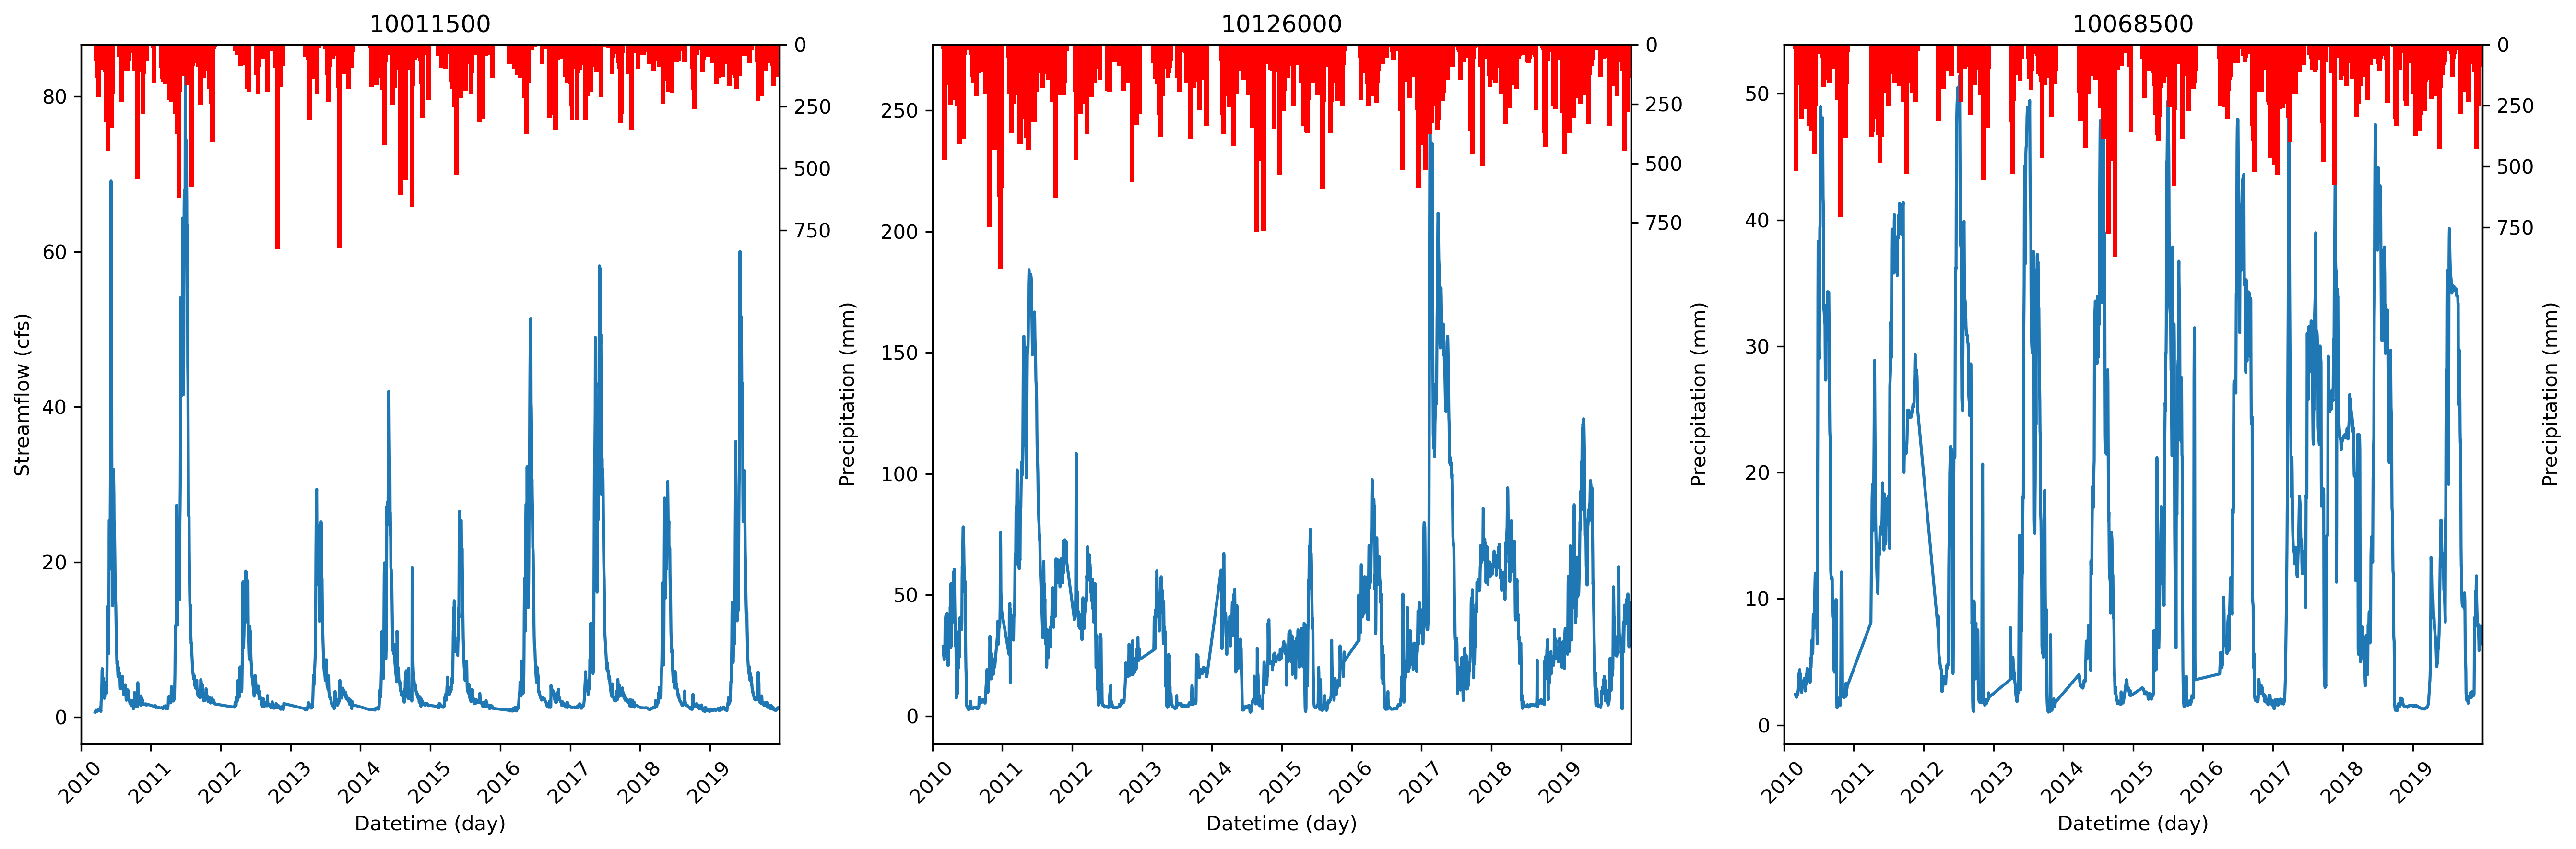

CPU times: user 11 s, sys: 32.9 ms, total: 11 s
Wall time: 11 s


In [65]:
%%time
# Calculate the number of subplots needed based on the number of unique stations.
n_subplots = len(station_list)
# Determine the number of columns in the subplot grid by taking the ceiling of the square root of 'n_subplots'.
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))
# Determine the number of rows in the subplot grid by dividing 'n_subplots' by 'n_cols' and taking the ceiling of that.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the figure size for the subplots.
figsize = (18, 6)
# Create a grid of subplots with specified number of rows and columns and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=300)
# Flatten the axes array for easier iteration.
axes = axes.flatten()

# Iterate over the axes to plot the data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        year = 2010
        # Extract the data for the current station from the dataset.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        temp_df_1 = temp_df_1[(temp_df_1.datetime.dt.year >= year) & (temp_df_1.datetime.dt.year < year+10)]
        # Set 'datetime' as the index for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot the 'flow_cfs' data on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cms'])
        # Set the x-axis limits from the first to the last year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Rotate x-axis labels for better readability.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a second y-axis for the precipitation data.
        ax2 = ax.twinx()
        # Plot the 'precip(mm)' data as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['precipitation'], label='Inverted', color='red', width=25)
        # Set the y-axis limits for precipitation, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['precipitation']) + 2000, 0)
        # Set the label for the secondary y-axis.
        ax2.set_ylabel('Precipitation (mm)')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['precipitation']), 250))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


The next plot shows SWE vs streamflow. 

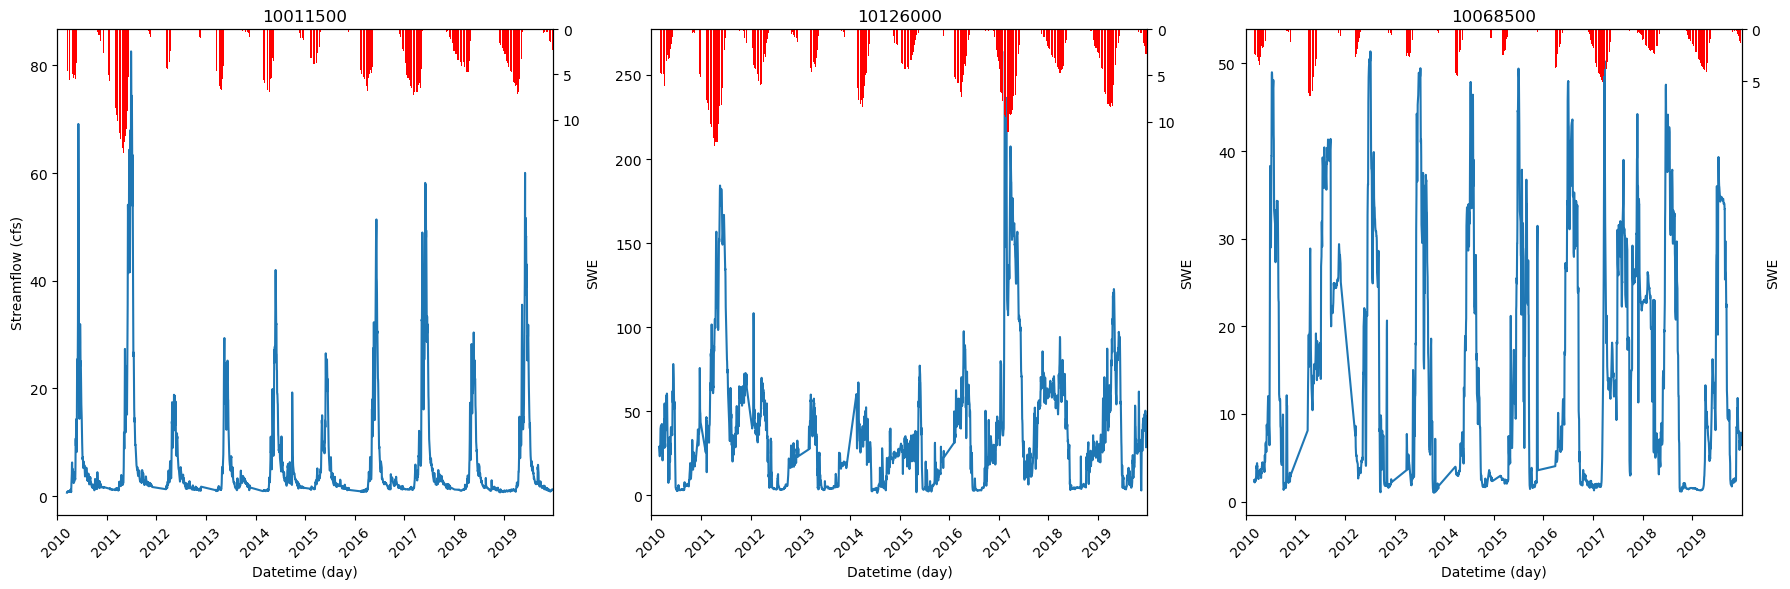

CPU times: user 10.4 s, sys: 5.91 ms, total: 10.4 s
Wall time: 10.4 s


In [67]:
%%time
# Initialize variables for the number of plots, columns, and rows based on the number of unique stations.
n_subplots = len(station_list)
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))  # Calculate columns as the ceiling of the square root of number of subplots.
n_rows = int(math.ceil(n_subplots / n_cols))  # Calculate rows as the ceiling of the ratio of subplots to columns.
figsize = (18, 6)  # Set the figure size for the plot.
# Create a figure and a grid of subplots with the specified number of rows and columns.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # Flatten the axes array for easier iteration.

# Iterate over each axis to plot data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:  # Check if the current index is less than the number of subplots to populate.
        # Extract data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        temp_df_1 = temp_df_1[(temp_df_1.datetime.dt.year >= year) & (temp_df_1.datetime.dt.year < year+10)]
        # Set 'datetime' as the index for the DataFrame for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot 'flow_cfs' on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cms'])
        # Set x-axis limits from the minimum to maximum year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Get current x-tick labels and set their rotation for better visibility.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a secondary y-axis for Snow Water Equivalent (SWE).
        ax2 = ax.twinx()
        # Plot SWE as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['swe'], label='Inverted', color='red')
        # Set the y-axis limits for SWE, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['swe']) + 40, 0)
        # Set label for the secondary y-axis.
        ax2.set_ylabel('SWE')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['swe']), 5))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


Next, we will use histograms for streamflow to see its skewness and distribution. 

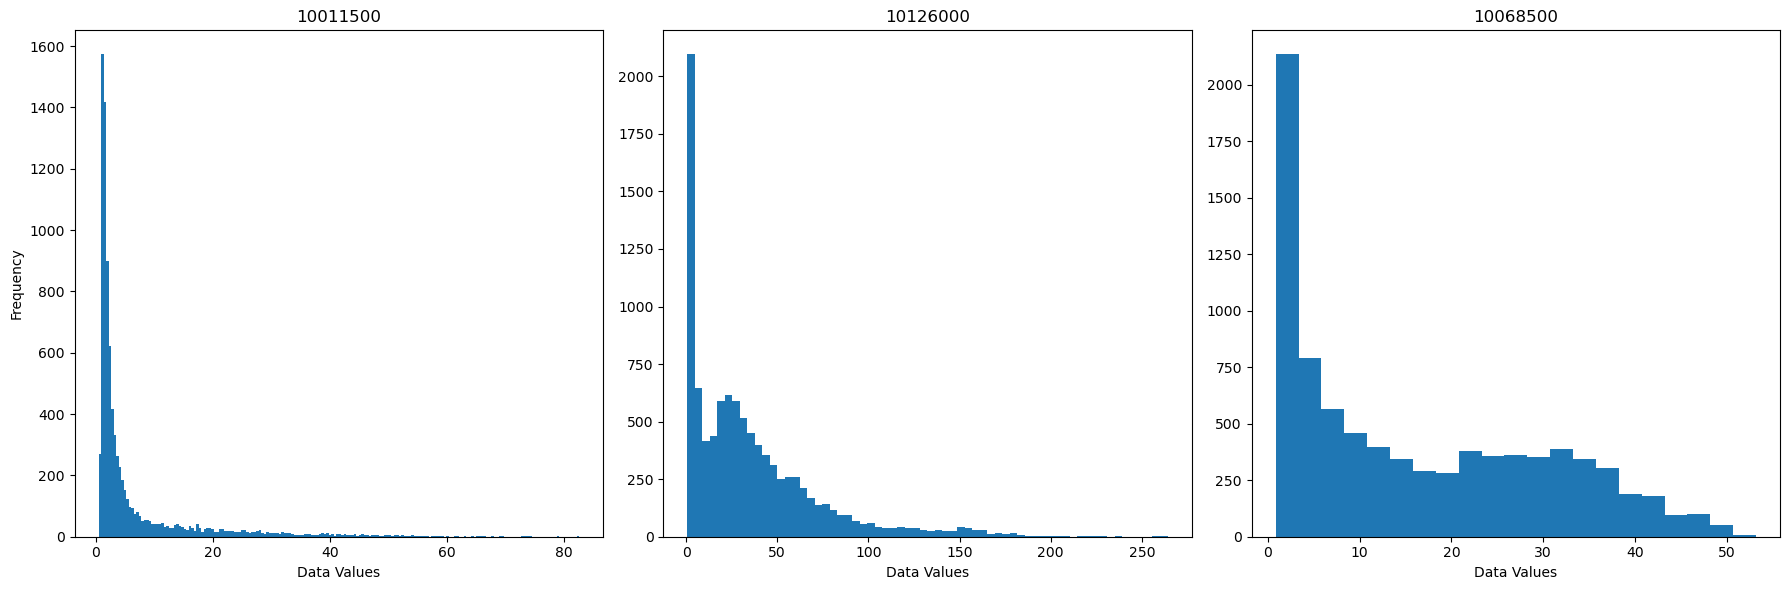

CPU times: user 763 ms, sys: 6.03 ms, total: 769 ms
Wall time: 767 ms


In [6]:
%%time
# Determine the number of subplots based on the number of unique stations.
n_subplots = len(station_list)
# Calculate the number of columns for subplots based on the square root of the number of subplots.
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))
# Calculate the number of rows for subplots based on the total subplots and columns.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the size of the figure for subplots.
figsize = (18, 6)
# Create a figure and a grid of subplots with the specified rows and columns, and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # Flatten the axes array for easier access in looping.

# Loop through each axis to plot histogram for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        # Extract the data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]

        # Calculate the Interquartile Range (IQR) for the 'flow_cfs' data.
        IQR = np.percentile(temp_df_1['flow_cms'], 75) - np.percentile(temp_df_1['flow_cms'], 25)
        # Calculate the bin width using Freedman-Diaconis rule which is optimal for histogram.
        bin_width = 2 * IQR * (len(temp_df_1['flow_cms']) ** (-1/3))
        # Calculate the number of bins for the histogram using the calculated bin width.
        bins_fd = int((max(temp_df_1['flow_cms']) - min(temp_df_1['flow_cms'])) / bin_width)

        # Plot a histogram of 'flow_cfs' for the station with calculated bins.
        ax.hist(temp_df_1['flow_cms'], bins=bins_fd)

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Data Values')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Frequency')
    else:
        # Hide unused subplots.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


#### 4.4. Splitting the Data
We split 80 percent of the data for trainging and the rest for testing the model, but we do not shuffele the data since LSTM needs to get the data in the right temporal sequence to understand the temporal relationships. So we will split the data based on the dates, 1986-2014 (80%) training and 2014-2020 (20%) testing. 
 


In [5]:
data_train, data_test = data_split(dataset)

#### 4.6. Scaling the Data and Adding Lookbacks 
- To use Neural Network models, such as LSTM we need to scale the data between zero and one since the scale of data for each feature can be very different than the other ones. Different scales hinders the model from learning. There are several functions for scaling or you can even create your own function, but for this tutoral we will use the famous MinMax() function from Sklearn library. 
- LSTM needs data from previous time steps with lag to capture the temporal relationship in the data. So we add the data with lag to our dataset and call it lookbacks. 
- A time series of n timesteps can produce approximately n lookbacks (e.g., a window can start at any time step given the lookbacks does not exceed the boundaries of the time series).
- Since we are using Pytorch we need to convert our data to Tensors with three dimensions. The first dimension will show us the batch size, number of the lookbacks will be the second dimension, and the third column will show the number of features. 
- For example, if our batc size is 100 with three features and four step lookbacks, the Tensor of input data would have (100, 4, 3) dimension. The four step lookbacks means, if our goal is to predict t+1 step the model would use the data from t, t-1, t-2, and t-3 time steps. 
- Druing adding the lookbacks we will also seperate the features and target datasets.  

In [6]:
length_lookback = 2
x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, scaler_x, scaler_y, y_train, x_test, y_test = data_prepare(data_train, data_test, length_lookback=length_lookback)

In [7]:
data_train.to_pickle(f"{output_path}train_dataset.pkl")
data_test.to_pickle(f"{output_path}test_dataset.pkl")

## 5. Model Development 
#### 5.1. Defining the Model
- As mentioned, we will use a Bidirectional LSTM model which has a simple two layer architecture and Pytorch library. 
- The first layer in our model is a bidirecional LSTM layer which is similar to normal LSTM and the only difference is that you have to turn 'bidirectional' variable to 'True' in the layer variables. 
- The second layer is fully connected layer which will get the ouptuts of LSTM layer, so we should multiple the neurans number (hidden_size variable) by two. 


#### 5.2. Tuning the Hyperparameters
- We have several hyperparameters for our LSTM model, which we have to tune so that we can have the best possible results. 
- The tunning process can be done manually or by using optimization algorithms, in this tutorial we will use the values that we have identified to work best. 

In [20]:
# Load the train and test dataset
data_train = pd.read_pickle(f"{output_path}train_dataset.pkl")
data_test = pd.read_pickle(f"{output_path}test_dataset.pkl")

# station_list ['10154200', '10155000', '10156000']
selected_station = station_list[0]
epochs = 10 # We don't change it.
input_size = x_train_scaled[selected_station].shape[2]
# Move the model and data to GPU. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feed the data to DataLoader and TensorDataset Functions
x_train_tensor = torch.Tensor(x_train_scaled[selected_station].astype(float))
y_train_tensor = torch.Tensor(y_train_scaled[selected_station].astype(float))
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

# Define the initial parameters for the LSTM model.
params = {
    'batch_size': 50,
    'learning_rate': 1e-4,
    'hidden_size': 300,
    'num_layers': 1,
}

tuning_game(input_size, device, train_dataset, epochs, params, selected_station)

params

Initial score: 0.10802228554975761 with params: {'batch_size': 50, 'learning_rate': 0.0001, 'hidden_size': 300, 'num_layers': 1}


Do you want to change any variable? (y/n):  y
Which variable number? (batch_size(1)/learning_rate(2)/hidden_size(3)/num_layers(4)): 2
Enter the new value for learning_rate (previous value 0.0001):  1


Previous Mean Score: 0.108
New Mean Score: 3.748 


Do you want to keep the new variable?(y/n):  y
Do you want to change any variable? (y/n):  n


Finished tuning.
Final parameters: {'batch_size': 50, 'learning_rate': 1.0, 'hidden_size': 300, 'num_layers': 1}.


{'batch_size': 50, 'learning_rate': 1.0, 'hidden_size': 300, 'num_layers': 1}

In [21]:

# Initialize empty DataFrames to store evaluation results if not already defined.
EvalDF_all_rf = pd.DataFrame()
SupplyEvalDF_all_rf = pd.DataFrame()
df_eval_rf = pd.DataFrame()
df_result_data= {}



bilstm_model = CustomBiLSTM(input_size, params['hidden_size'], params['num_layers'], 1, device, embedding=False, station_list=station_list)

x_test_tensor = torch.Tensor(x_test_scaled[selected_station].astype(float))
y_test_tensor = torch.Tensor(y_test_scaled[selected_station].astype(float))
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
yhat_test_scaled, val_loss = bilstm_model.evaluate_model(test_loader)

# Inverse transform the scaled predictions to their original scale.
yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1))

# Assuming EvalTable is a predefined function that compares predictions to actuals and returns evaluation DataFrames.
EvalDF_all_rf_temp, SupplyEvalDF_all_rf_temp, df_eval_rf_temp = EvalTable(yhat_test.reshape(-1), data_test[data_test.station_id == selected_station][2:], 'lstm')

df_result_data[selected_station] = data_test[data_test.station_id == selected_station][2:].copy()

df_result_data[selected_station]['lstm_flow'] = yhat_test

# Append the results from each station to the respective DataFrame.
EvalDF_all_rf = pd.concat([EvalDF_all_rf, EvalDF_all_rf_temp], ignore_index=True)
SupplyEvalDF_all_rf = pd.concat([SupplyEvalDF_all_rf, SupplyEvalDF_all_rf_temp], ignore_index=True)
df_eval_rf = pd.concat([df_eval_rf, df_eval_rf_temp], ignore_index=True)

print("Model Performance for Daily cfs")
display(EvalDF_all_rf)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all_rf)

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_RMSE,lstm_RMSE,NWM_PBias,lstm_PBias,NWM_KGE,lstm_KGE
0,10011500,10375648,4.65,16.3,8.99,-203.93,0.77,-1.31


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_RMSE,lstm_RMSE,NWM_PBias,lstm_PBias,NWM_KGE,lstm_KGE,Obs_vol,NWM_vol,lstm_vol,NWM_vol_err,lstm_vol_err,NWM_vol_Perc_diff,lstm_vol_Perc_diff
0,10011500,10375648,16670.1,140252.52,7.2,-157.36,0.9,-0.86,136857.97,100817.19,366653.47,-36040.77,229795.5,-26.33,167.91


In [11]:
import optuna

length_lookback = 10
x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, scaler_x, scaler_y, y_train, x_test, y_test = data_prepare(data_train, data_test, length_lookback=length_lookback)
selected_station = station_list[0]
epochs = 5 
input_size = x_train_scaled[selected_station].shape[2]

# Move the model and data to the GPU if available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute lengths for 80/20 split
x_train_tensor = torch.Tensor(x_train_scaled[selected_station].astype(float))
y_train_tensor = torch.Tensor(y_train_scaled[selected_station].astype(float))
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len

# Split dataset
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

# Create DataLoaders
train_loader = {selected_station: DataLoader(train_dataset, batch_size=50, shuffle=True)}
val_loader = {selected_station: DataLoader(val_dataset, batch_size=50, shuffle=False)}

def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=False)

    # Create the Model
    bilstm_model = CustomBiLSTM(input_size, hidden_size, num_layers, 1, device, embedding=False, station_list=station_list[0:1])
    
    # Create the Optimizer
    bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=0)
    
    # Run the training function
    model_parameters = bilstm_model.train_model(train_loader, epochs, bilstm_optimizer, early_stopping_patience=0, val_loader=None, tune='True')
        # print('hi')
    outputs, val_loss = bilstm_model.evaluate_model(val_loader[selected_station])
    return val_loss  # Minimize validation loss
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)


[I 2025-05-19 02:38:37,805] A new study created in memory with name: no-name-a927bc49-822e-47e7-8de0-2ae61dd3cc47


Epoch 1/5, Training Loss: 0.09950178116559982 Validation Loss: 0
Epoch 2/5, Training Loss: 0.057308800518512726 Validation Loss: 0
Epoch 3/5, Training Loss: 0.09955717623233795 Validation Loss: 0
Epoch 4/5, Training Loss: 0.08020396530628204 Validation Loss: 0


[I 2025-05-19 02:38:39,884] Trial 0 finished with value: 0.07106932914919323 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.007669143753122852}. Best is trial 0 with value: 0.07106932914919323.


Epoch 5/5, Training Loss: 0.10630140453577042 Validation Loss: 0
Epoch 1/5, Training Loss: 0.11939798295497894 Validation Loss: 0
Epoch 2/5, Training Loss: 0.09678582102060318 Validation Loss: 0
Epoch 3/5, Training Loss: 0.11382932215929031 Validation Loss: 0
Epoch 4/5, Training Loss: 0.08079412579536438 Validation Loss: 0


[I 2025-05-19 02:38:45,181] Trial 1 finished with value: 0.06532143511705929 and parameters: {'hidden_size': 112, 'num_layers': 3, 'lr': 0.008660973827669824}. Best is trial 1 with value: 0.06532143511705929.


Epoch 5/5, Training Loss: 0.060397036373615265 Validation Loss: 0
Epoch 1/5, Training Loss: 0.10699155926704407 Validation Loss: 0
Epoch 2/5, Training Loss: 0.05942757800221443 Validation Loss: 0
Epoch 3/5, Training Loss: 0.052697475999593735 Validation Loss: 0
Epoch 4/5, Training Loss: 0.10699092596769333 Validation Loss: 0


[I 2025-05-19 02:38:47,227] Trial 2 finished with value: 0.07507280600659641 and parameters: {'hidden_size': 117, 'num_layers': 1, 'lr': 0.002402786169794526}. Best is trial 1 with value: 0.06532143511705929.


Epoch 5/5, Training Loss: 0.06380949914455414 Validation Loss: 0
Epoch 1/5, Training Loss: 0.09097931534051895 Validation Loss: 0
Epoch 2/5, Training Loss: 0.07550099492073059 Validation Loss: 0
Epoch 3/5, Training Loss: 0.09146705269813538 Validation Loss: 0
Epoch 4/5, Training Loss: 0.06018558517098427 Validation Loss: 0


[I 2025-05-19 02:38:51,216] Trial 3 finished with value: 0.06383662164947133 and parameters: {'hidden_size': 111, 'num_layers': 2, 'lr': 0.0030814373715245956}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.10429505258798599 Validation Loss: 0
Epoch 1/5, Training Loss: 0.09547917544841766 Validation Loss: 0
Epoch 2/5, Training Loss: 0.09438179433345795 Validation Loss: 0
Epoch 3/5, Training Loss: 0.031191229820251465 Validation Loss: 0
Epoch 4/5, Training Loss: 0.06738017499446869 Validation Loss: 0


[I 2025-05-19 02:38:54,071] Trial 4 finished with value: 0.06386369397794758 and parameters: {'hidden_size': 53, 'num_layers': 2, 'lr': 0.008349391989103899}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.08375845849514008 Validation Loss: 0
Epoch 1/5, Training Loss: 0.07536908239126205 Validation Loss: 0
Epoch 2/5, Training Loss: 0.05670519545674324 Validation Loss: 0
Epoch 3/5, Training Loss: 0.07433732599020004 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04136650264263153 Validation Loss: 0


[I 2025-05-19 02:39:00,106] Trial 5 finished with value: 0.07492839866950188 and parameters: {'hidden_size': 121, 'num_layers': 3, 'lr': 0.005872302104458165}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.08254297822713852 Validation Loss: 0
Epoch 1/5, Training Loss: 0.0864749625325203 Validation Loss: 0
Epoch 2/5, Training Loss: 0.07282555848360062 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08931349962949753 Validation Loss: 0
Epoch 4/5, Training Loss: 0.059816498309373856 Validation Loss: 0


[I 2025-05-19 02:39:03,915] Trial 6 finished with value: 0.0683892444236043 and parameters: {'hidden_size': 103, 'num_layers': 2, 'lr': 0.005717904657733478}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.11038897931575775 Validation Loss: 0
Epoch 1/5, Training Loss: 0.13913075625896454 Validation Loss: 0
Epoch 2/5, Training Loss: 0.11533363908529282 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08146726340055466 Validation Loss: 0
Epoch 4/5, Training Loss: 0.054891522973775864 Validation Loss: 0


[I 2025-05-19 02:39:05,901] Trial 7 finished with value: 0.07982392595322044 and parameters: {'hidden_size': 97, 'num_layers': 1, 'lr': 0.00923672460793338}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.13137459754943848 Validation Loss: 0
Epoch 1/5, Training Loss: 0.12020155042409897 Validation Loss: 0
Epoch 2/5, Training Loss: 0.0938020572066307 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08136748522520065 Validation Loss: 0
Epoch 4/5, Training Loss: 0.058925025165081024 Validation Loss: 0


[I 2025-05-19 02:39:10,081] Trial 8 finished with value: 0.06925083775027299 and parameters: {'hidden_size': 62, 'num_layers': 3, 'lr': 0.0046680223967712105}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.05174161493778229 Validation Loss: 0
Epoch 1/5, Training Loss: 0.1513109803199768 Validation Loss: 0
Epoch 2/5, Training Loss: 0.09841355681419373 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08219495415687561 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04954943433403969 Validation Loss: 0


[I 2025-05-19 02:39:13,259] Trial 9 finished with value: 0.06748255001909939 and parameters: {'hidden_size': 76, 'num_layers': 2, 'lr': 0.0014156549282318372}. Best is trial 3 with value: 0.06383662164947133.


Epoch 5/5, Training Loss: 0.029386963695287704 Validation Loss: 0
Epoch 1/5, Training Loss: 0.09532046318054199 Validation Loss: 0
Epoch 2/5, Training Loss: 0.039102956652641296 Validation Loss: 0
Epoch 3/5, Training Loss: 0.05275413766503334 Validation Loss: 0
Epoch 4/5, Training Loss: 0.06370159983634949 Validation Loss: 0


[I 2025-05-19 02:39:15,782] Trial 10 finished with value: 0.06306268196598983 and parameters: {'hidden_size': 37, 'num_layers': 2, 'lr': 0.0033678923521701385}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.04410329833626747 Validation Loss: 0
Epoch 1/5, Training Loss: 0.14016753435134888 Validation Loss: 0
Epoch 2/5, Training Loss: 0.1164015531539917 Validation Loss: 0
Epoch 3/5, Training Loss: 0.04562372714281082 Validation Loss: 0
Epoch 4/5, Training Loss: 0.0203967597335577 Validation Loss: 0


[I 2025-05-19 02:39:18,267] Trial 11 finished with value: 0.0647910687106627 and parameters: {'hidden_size': 34, 'num_layers': 2, 'lr': 0.002992415748389522}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.07334323972463608 Validation Loss: 0
Epoch 1/5, Training Loss: 0.0862378180027008 Validation Loss: 0
Epoch 2/5, Training Loss: 0.058199748396873474 Validation Loss: 0
Epoch 3/5, Training Loss: 0.06830142438411713 Validation Loss: 0
Epoch 4/5, Training Loss: 0.08802545070648193 Validation Loss: 0


[I 2025-05-19 02:39:21,608] Trial 12 finished with value: 0.07367159030687662 and parameters: {'hidden_size': 88, 'num_layers': 2, 'lr': 0.0005269527235015701}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.06845170259475708 Validation Loss: 0
Epoch 1/5, Training Loss: 0.11245957762002945 Validation Loss: 0
Epoch 2/5, Training Loss: 0.10867481678724289 Validation Loss: 0
Epoch 3/5, Training Loss: 0.04545886442065239 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04097059369087219 Validation Loss: 0


[I 2025-05-19 02:39:24,080] Trial 13 finished with value: 0.06384441610655667 and parameters: {'hidden_size': 34, 'num_layers': 2, 'lr': 0.003897406074855162}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.04031692445278168 Validation Loss: 0
Epoch 1/5, Training Loss: 0.12463773787021637 Validation Loss: 0
Epoch 2/5, Training Loss: 0.04017571732401848 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08015428483486176 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04931436851620674 Validation Loss: 0


[I 2025-05-19 02:39:27,098] Trial 14 finished with value: 0.06492083239150637 and parameters: {'hidden_size': 72, 'num_layers': 2, 'lr': 0.0023838183221430997}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.07339668273925781 Validation Loss: 0
Epoch 1/5, Training Loss: 0.13333767652511597 Validation Loss: 0
Epoch 2/5, Training Loss: 0.06197263300418854 Validation Loss: 0
Epoch 3/5, Training Loss: 0.037867411971092224 Validation Loss: 0
Epoch 4/5, Training Loss: 0.07213644683361053 Validation Loss: 0


[I 2025-05-19 02:39:28,753] Trial 15 finished with value: 0.0782557659678989 and parameters: {'hidden_size': 49, 'num_layers': 1, 'lr': 0.006876817476763402}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.05524265766143799 Validation Loss: 0
Epoch 1/5, Training Loss: 0.05847668647766113 Validation Loss: 0
Epoch 2/5, Training Loss: 0.0631692036986351 Validation Loss: 0
Epoch 3/5, Training Loss: 0.05606945976614952 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04488012567162514 Validation Loss: 0


[I 2025-05-19 02:39:33,549] Trial 16 finished with value: 0.07422210225536499 and parameters: {'hidden_size': 86, 'num_layers': 3, 'lr': 0.0036089686817521328}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.06447511911392212 Validation Loss: 0
Epoch 1/5, Training Loss: 0.04588944837450981 Validation Loss: 0
Epoch 2/5, Training Loss: 0.06210576742887497 Validation Loss: 0
Epoch 3/5, Training Loss: 0.08596619218587875 Validation Loss: 0
Epoch 4/5, Training Loss: 0.07945743203163147 Validation Loss: 0


[I 2025-05-19 02:39:37,282] Trial 17 finished with value: 0.06409436427516702 and parameters: {'hidden_size': 99, 'num_layers': 2, 'lr': 0.001261864654597846}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.09772725403308868 Validation Loss: 0
Epoch 1/5, Training Loss: 0.10846412181854248 Validation Loss: 0
Epoch 2/5, Training Loss: 0.09143225103616714 Validation Loss: 0
Epoch 3/5, Training Loss: 0.05908438190817833 Validation Loss: 0
Epoch 4/5, Training Loss: 0.08431913703680038 Validation Loss: 0


[I 2025-05-19 02:39:39,073] Trial 18 finished with value: 0.07082263679232126 and parameters: {'hidden_size': 63, 'num_layers': 1, 'lr': 0.004276058530700783}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.08335861563682556 Validation Loss: 0
Epoch 1/5, Training Loss: 0.07131695747375488 Validation Loss: 0
Epoch 2/5, Training Loss: 0.06924799084663391 Validation Loss: 0
Epoch 3/5, Training Loss: 0.10313238203525543 Validation Loss: 0
Epoch 4/5, Training Loss: 0.04867582023143768 Validation Loss: 0


[I 2025-05-19 02:39:43,061] Trial 19 finished with value: 0.07265947851133936 and parameters: {'hidden_size': 51, 'num_layers': 3, 'lr': 0.00541684029402814}. Best is trial 10 with value: 0.06306268196598983.


Epoch 5/5, Training Loss: 0.052318818867206573 Validation Loss: 0
Best hyperparameters: {'hidden_size': 37, 'num_layers': 2, 'lr': 0.0033678923521701385}


#### 5.3. Training and Testing the Model
- If we want to use GPUs to run the model before we feed the data to the training fucntion we have to transfer the data and the model to the GPU.
- Then we will use the TensorDataset function as wrapper for our feature and target to combine them together.   
- Next, we should use the DataLoader function of the Pytorch library. DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU. 
- We will use Adam optimizer for calculating the weights and biases. 

In [8]:
params = {
    'batch_size': 50,
    'learning_rate': 1e-3,
    'hidden_size': 200,
    'num_layers': 1,
}

length_lookback = 10
x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, scaler_x, scaler_y, y_train, x_test, y_test = data_prepare(data_train, data_test, length_lookback=length_lookback)

epochs = 10
batch_size = params['batch_size']
learning_rate = params['learning_rate']
hidden_size = params['hidden_size']
num_layers = params['num_layers']
input_size = x_train_scaled[list(x_train_scaled.keys())[0]].shape[2]
path_model = f'{output_path}model_param_station.pth'

# Move the model and data to GPU. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [9]:
train_loader= {}

for station_id in station_list:

    x_train_tensor = torch.Tensor(x_train_scaled[station_id].astype(float))
    y_train_tensor = torch.Tensor(y_train_scaled[station_id].astype(float))
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader[station_id] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [13]:
%%time
# Create the Model
bilstm_model = CustomBiLSTM(input_size, hidden_size, num_layers, 1, device, embedding=False, station_list=station_list)

# Create the Optimizer
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=0)

# Run the training function
model_parameters = bilstm_model.train_model(train_loader, epochs, bilstm_optimizer, early_stopping_patience=0, val_loader=None)

# Save the Model Parameters
bilstm_model.save_model(path_model)


Epoch 1/10, Training Loss: 0.4397907257080078 Validation Loss: 0
Epoch 2/10, Training Loss: 0.4378092586994171 Validation Loss: 0
Epoch 3/10, Training Loss: 0.1733306497335434 Validation Loss: 0
Epoch 4/10, Training Loss: 0.19970470666885376 Validation Loss: 0
Epoch 5/10, Training Loss: 0.17687317728996277 Validation Loss: 0
Epoch 6/10, Training Loss: 0.2970524728298187 Validation Loss: 0
Epoch 7/10, Training Loss: 0.23946179449558258 Validation Loss: 0
Epoch 8/10, Training Loss: 0.14568091928958893 Validation Loss: 0
Epoch 9/10, Training Loss: 0.38724881410598755 Validation Loss: 0
Epoch 10/10, Training Loss: 0.07178176194429398 Validation Loss: 0
CPU times: user 2min 32s, sys: 296 ms, total: 2min 32s
Wall time: 19.1 s


## 6. Model Evaluation 
#### 6.1. Model Evaluation Metrics
- We fist have to transform the results to their original scale. 
- To evaluate our model we will use KGE, RMSE, and PBias metrics. 
- We will also compare the cumulative streamflow in each year. 

In [14]:
# Initialize empty DataFrames to store evaluation results if not already defined.
EvalDF_all_rf = pd.DataFrame()
SupplyEvalDF_all_rf = pd.DataFrame()
df_eval_rf = pd.DataFrame()
df_result_data= {}


# Iterate over each station name in the list of station IDs.
for station_name in station_list:
    x_test_tensor = torch.Tensor(x_test_scaled[station_name].astype(float))
    y_test_tensor = torch.Tensor(y_test_scaled[station_name].astype(float))
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
    yhat_test_scaled, val_loss = bilstm_model.evaluate_model(test_loader)
    
    # Inverse transform the scaled predictions to their original scale.
    yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1))
    
    # Assuming EvalTable is a predefined function that compares predictions to actuals and returns evaluation DataFrames.
    EvalDF_all_rf_temp, SupplyEvalDF_all_rf_temp, df_eval_rf_temp = EvalTable(yhat_test.reshape(-1), data_test[data_test.station_id == station_name][length_lookback:], 'lstm')

    df_result_data[station_name] = data_test[data_test.station_id == station_name][length_lookback:].copy()

    df_result_data[station_name]['lstm_flow'] = yhat_test

    # Append the results from each station to the respective DataFrame.
    EvalDF_all_rf = pd.concat([EvalDF_all_rf, EvalDF_all_rf_temp], ignore_index=True)
    SupplyEvalDF_all_rf = pd.concat([SupplyEvalDF_all_rf, SupplyEvalDF_all_rf_temp], ignore_index=True)
    df_eval_rf_ = pd.concat([df_eval_rf, df_eval_rf_temp], ignore_index=True)

print("Model Performance for Daily cfs")
display(EvalDF_all_rf)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all_rf)

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_RMSE,lstm_RMSE,NWM_PBias,lstm_PBias,NWM_KGE,lstm_KGE
0,10011500,10375648,4.66,4.85,8.99,5.64,0.77,0.73
1,10126000,10375648,40.75,23.47,-43.73,13.81,0.37,0.71
2,10068500,10375648,21.71,11.58,-34.35,18.99,0.06,0.56


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_RMSE,lstm_RMSE,NWM_PBias,lstm_PBias,NWM_KGE,lstm_KGE,Obs_vol,NWM_vol,lstm_vol,NWM_vol_err,lstm_vol_err,NWM_vol_Perc_diff,lstm_vol_Perc_diff
0,10011500,10375648,16679.03,18331.5,7.2,6.38,0.9,0.81,136857.97,100817.19,111336.39,-36040.77,-25521.58,-26.33,-18.65
1,10126000,10375648,287698.55,191425.66,-26.49,15.55,0.61,0.78,1158239.8,1768193.45,1082280.2,609953.7,-75959.55,52.66,-6.56
2,10068500,10375648,148565.95,106410.88,-43.07,23.47,0.42,0.52,191126.52,572058.8,282855.0,380932.29,91728.49,199.31,47.99


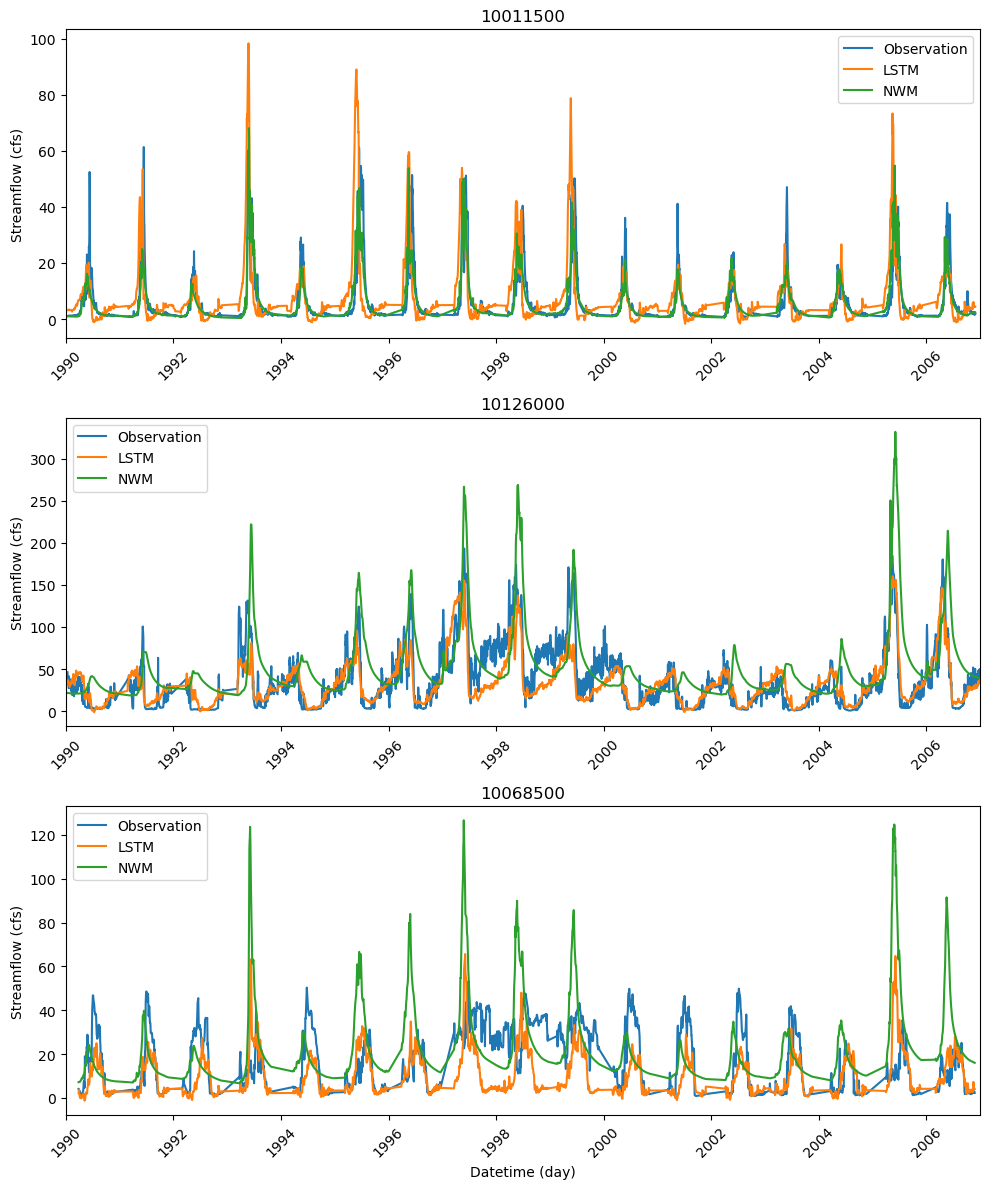

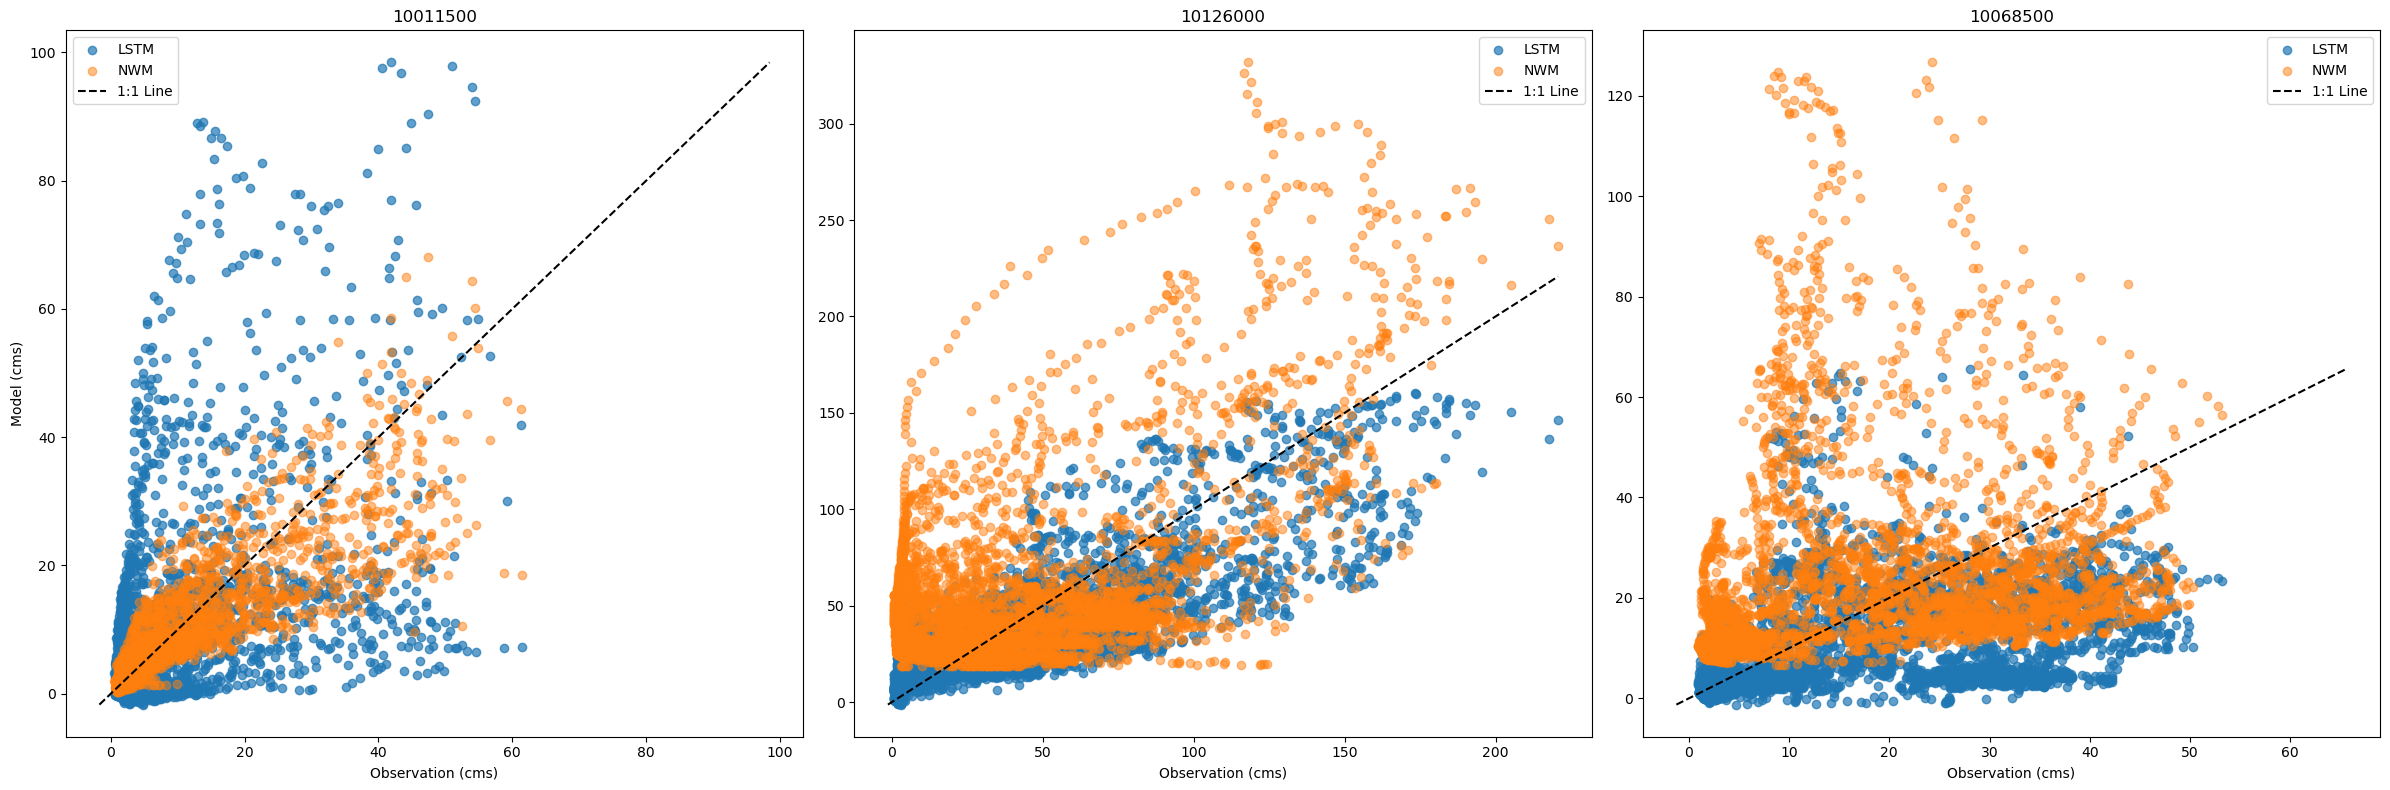

In [11]:
general_viz(df_result_data, station_list, 0)
general_viz(df_result_data, station_list, 1)


In [12]:
regime_eval(df_result_data, station_list)

,USGSid,NHDPlusid,NWM_RMSE,LSTM_RMSE,NWM_PBias,LSTM_PBias,NWM_KGE,LSTM_KGE,flow_type
0,10011500,10375648,0.65,3.49,-14.66,-233.99,-1.77,-11.34,low
1,10126000,10375648,43.46,8.06,-1707.61,-215.64,-22.83,-6.62,low
2,10068500,10375648,11.8,2.17,-574.87,-49.14,-11.98,-3.13,low
3,10011500,10375648,1.85,7.83,-11.83,-74.84,0.33,-2.8,normal
4,10126000,10375648,33.79,13.72,-52.41,-7.63,-0.33,0.6,normal
5,10068500,10375648,24.89,12.13,-70.7,24.53,-0.75,0.25,normal
6,10011500,10375648,9.89,21.36,18.59,6.97,0.61,-0.03,high
7,10126000,10375648,54.65,39.54,4.31,28.92,-0.24,0.55,high
8,10068500,10375648,18.97,24.35,35.62,59.85,-1.06,-0.29,high


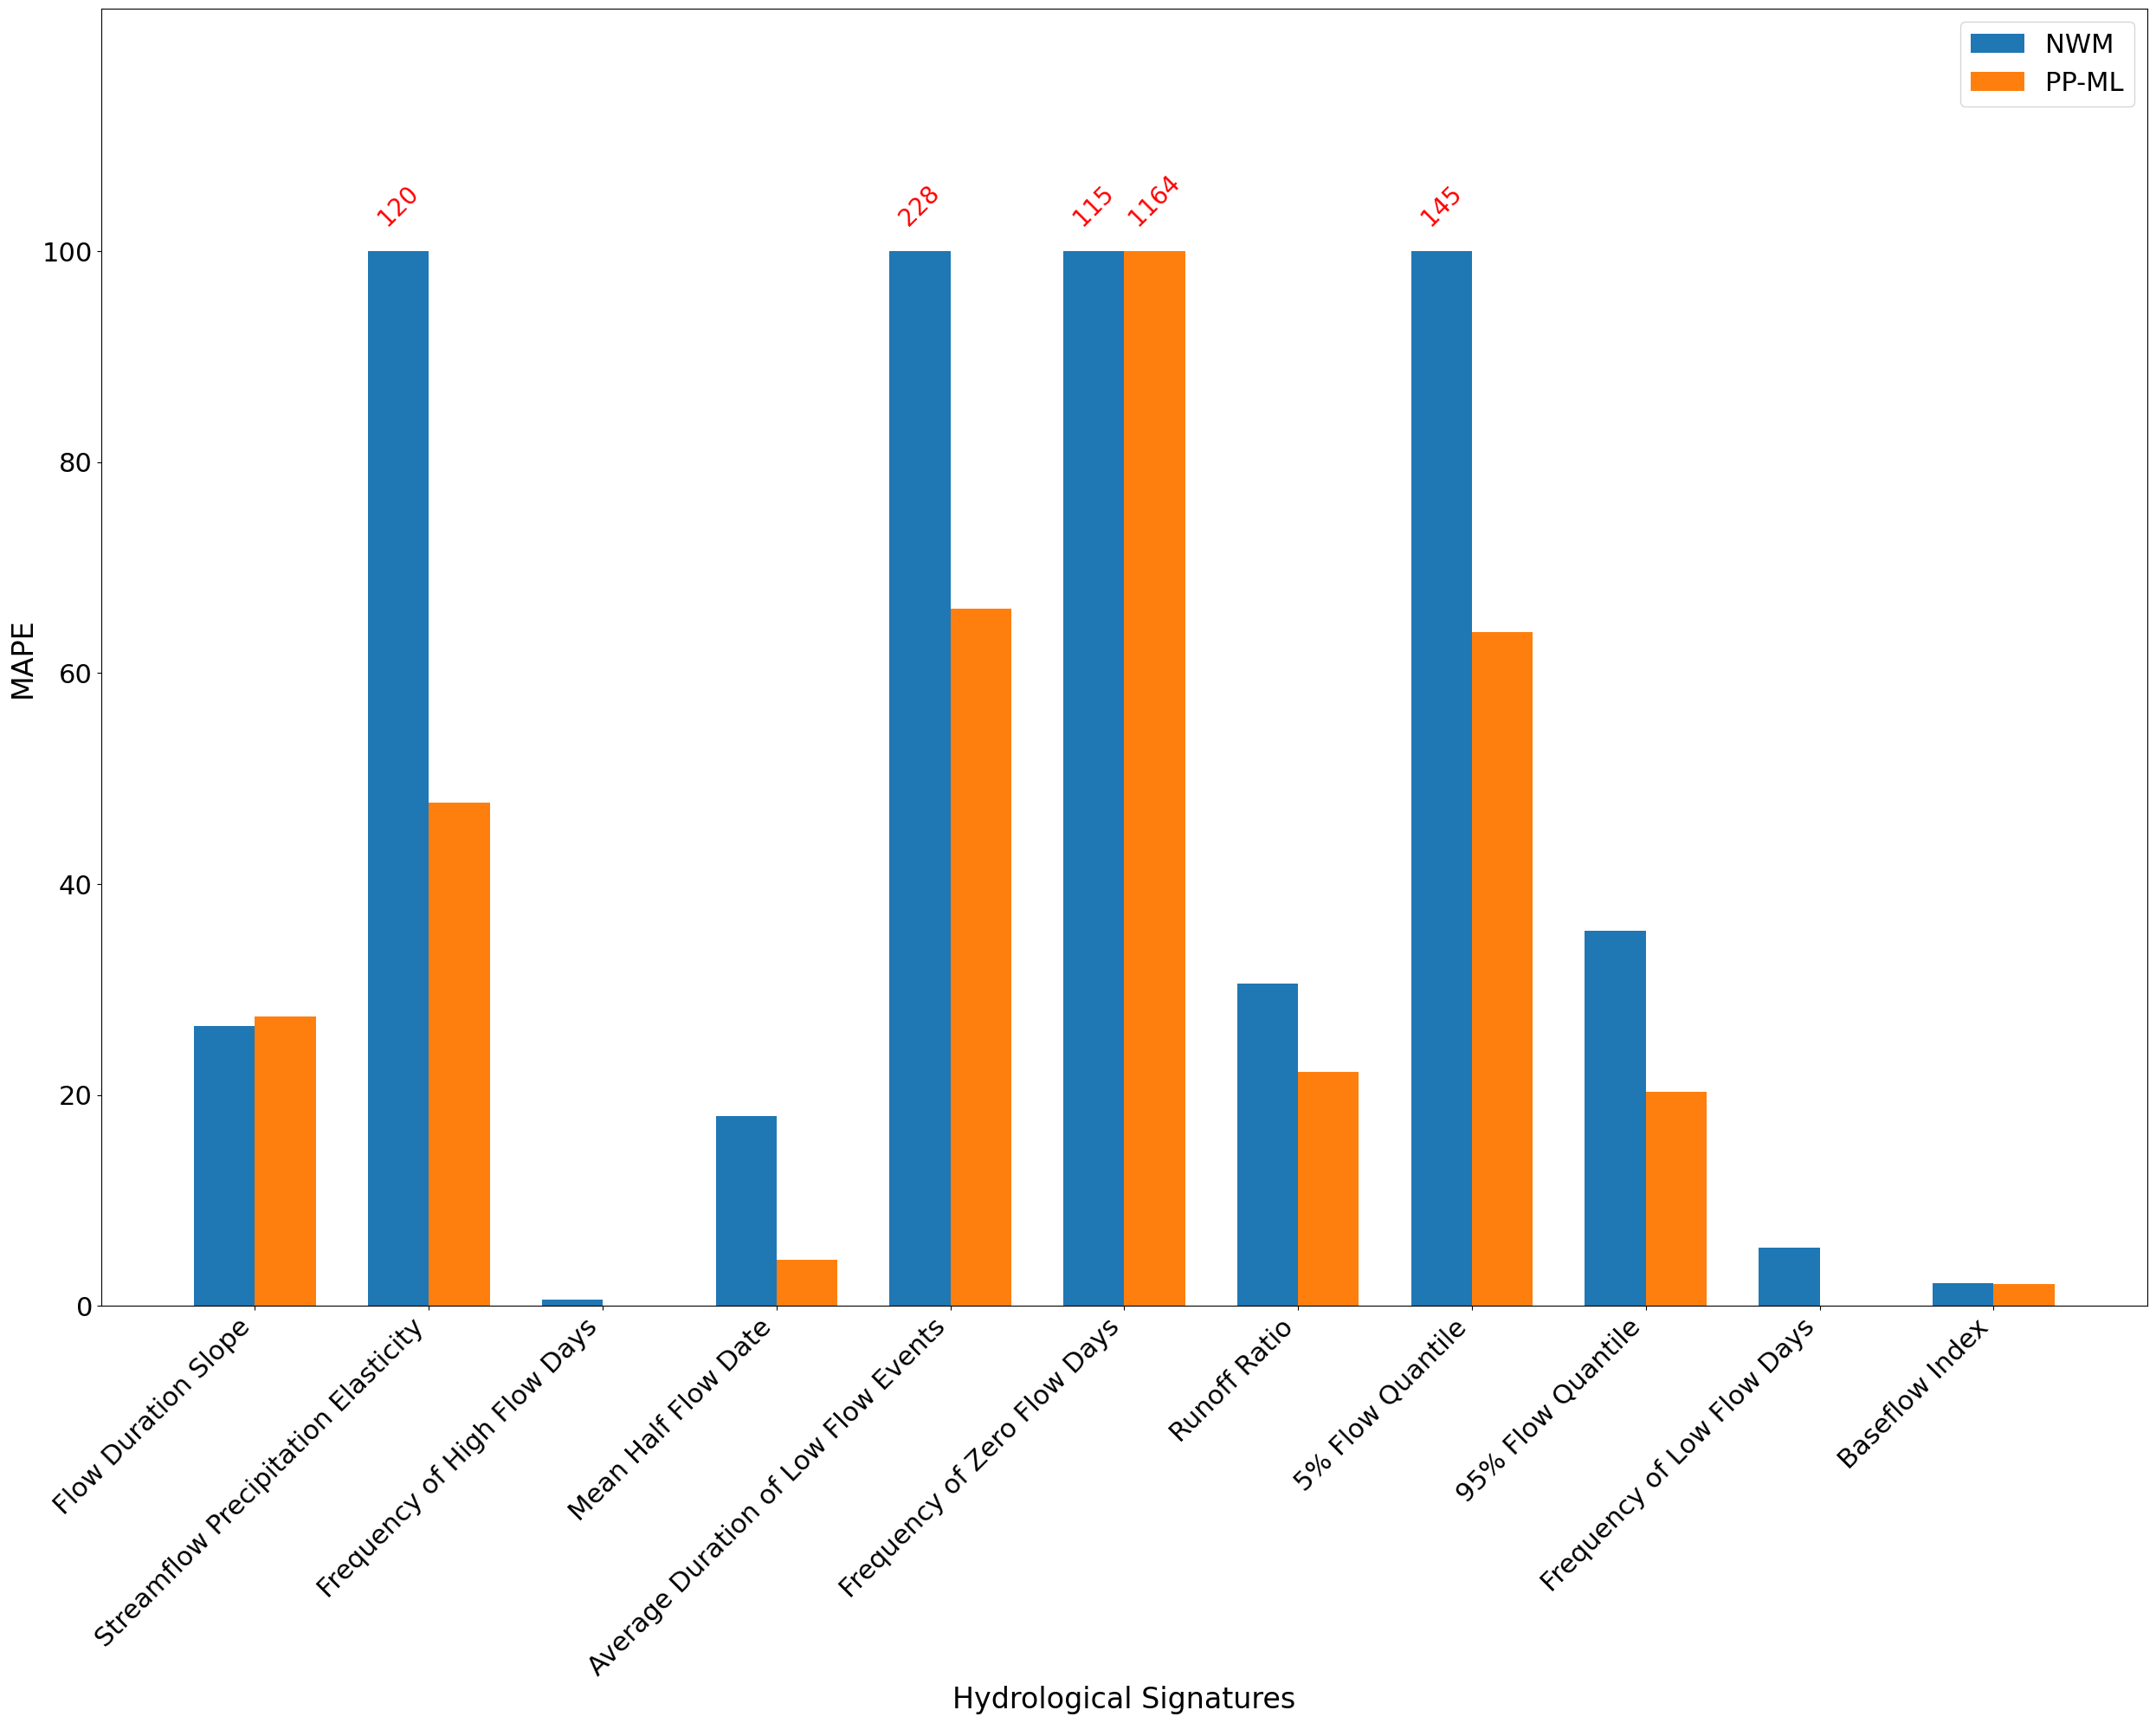

In [13]:
signature_eval(df_result_data, station_list, output_path)

In [17]:
duration = 2
eval_drought(df_result_data, station_list, duration, dataset, EvalDF_all_rf)

,station_id,NWM,LSTM
0,10011500,0.52,-0.15
1,10126000,0.29,0.39
2,10068500,-0.09,-0.47
